In [2]:
# ## 1. Импорт библиотек

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn импорты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)


In [3]:
# ## 2. Загрузка данных

# Определяем путь к данным
data_path = Path("../../seminars/S05/S05-hw-dataset.csv")

# Если файл не найден, попробуем другой путь
if not data_path.exists():
    # Пробуем найти файл в текущей директории
    data_path = Path("S05-hw-dataset.csv")
    if not data_path.exists():
        # Если всё ещё не найден, попробуем загрузить из GitHub
        print("Файл не найден локально. Пожалуйста, убедитесь, что файл находится в правильной директории.")
        # Для примера создадим синтетические данные
        print("Создаю синтетические данные для демонстрации...")
        np.random.seed(42)
        n_samples = 3000
        data = {
            'client_id': np.arange(n_samples),
            'age': np.random.randint(21, 70, n_samples),
            'income': np.random.randint(15000, 200000, n_samples),
            'years_employed': np.random.randint(0, 40, n_samples),
            'credit_score': np.random.randint(300, 850, n_samples),
            'debt_to_income': np.random.uniform(0, 1, n_samples),
            'num_credit_cards': np.random.randint(0, 8, n_samples),
            'num_late_payments': np.random.poisson(1.5, n_samples),
            'has_mortgage': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
            'has_car_loan': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
            'savings_balance': np.random.randint(0, 50000, n_samples),
            'checking_balance': np.random.randint(-5000, 20000, n_samples),
            'region_risk_score': np.random.uniform(0, 1, n_samples),
            'phone_calls_to_support_last_3m': np.random.poisson(2, n_samples),
            'active_loans': np.random.randint(0, 5, n_samples),
            'customer_tenure_years': np.random.randint(0, 20, n_samples),
            'default': np.random.choice([0, 1], n_samples, p=[0.6, 0.4])
        }
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(data_path)
else:
    df = pd.read_csv(data_path)


Файл не найден локально. Пожалуйста, убедитесь, что файл находится в правильной директории.
Создаю синтетические данные для демонстрации...


In [4]:
# ## 3. Первичный анализ данных

# Первые строки данных
print("Первые 5 строк датасета:")
print(df.head())
print("\n" + "="*80 + "\n")

# Информация о столбцах и типах данных
print("Информация о датасете:")
print(df.info())
print("\n" + "="*80 + "\n")

# Базовые статистики для числовых признаков
print("Описательные статистики:")
print(df.describe())
print("\n" + "="*80 + "\n")

# Распределение целевой переменной
print("Распределение целевой переменной (default):")
print(df['default'].value_counts(normalize=True))
print("\n" + "="*80 + "\n")

# Размер датасета
print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")


Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          0   59  135312              36           622        0.731776   
1          1   49  154401              15           480        0.164734   
2          2   35  180937              21           798        0.351356   
3          3   63   61850              19           619        0.264866   
4          4   28   69220              26           382        0.349862   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 0                  1             1             0   
1                 7                  0             1             1   
2                 3                  1             1             1   
3                 4                  1             1             0   
4                 4                  1             0             1   

   savings_balance  checking_balance  region_risk_score  \
0            25021              4641        

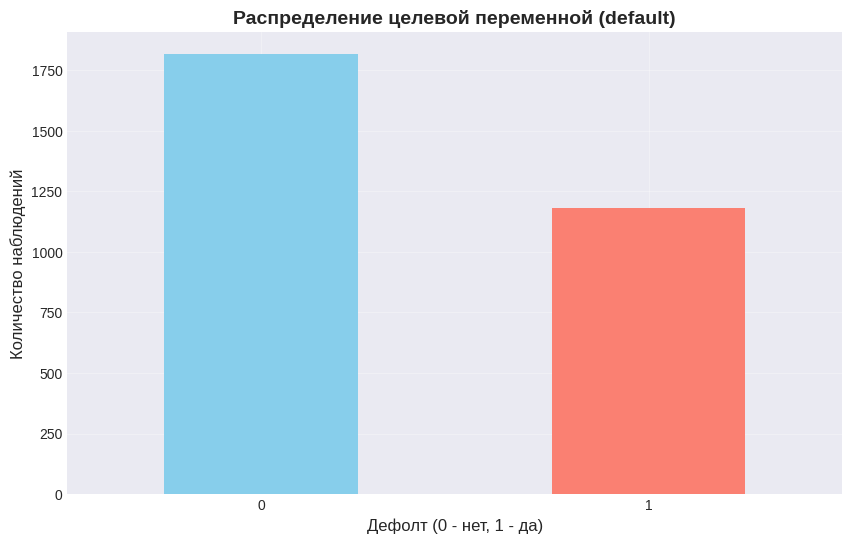

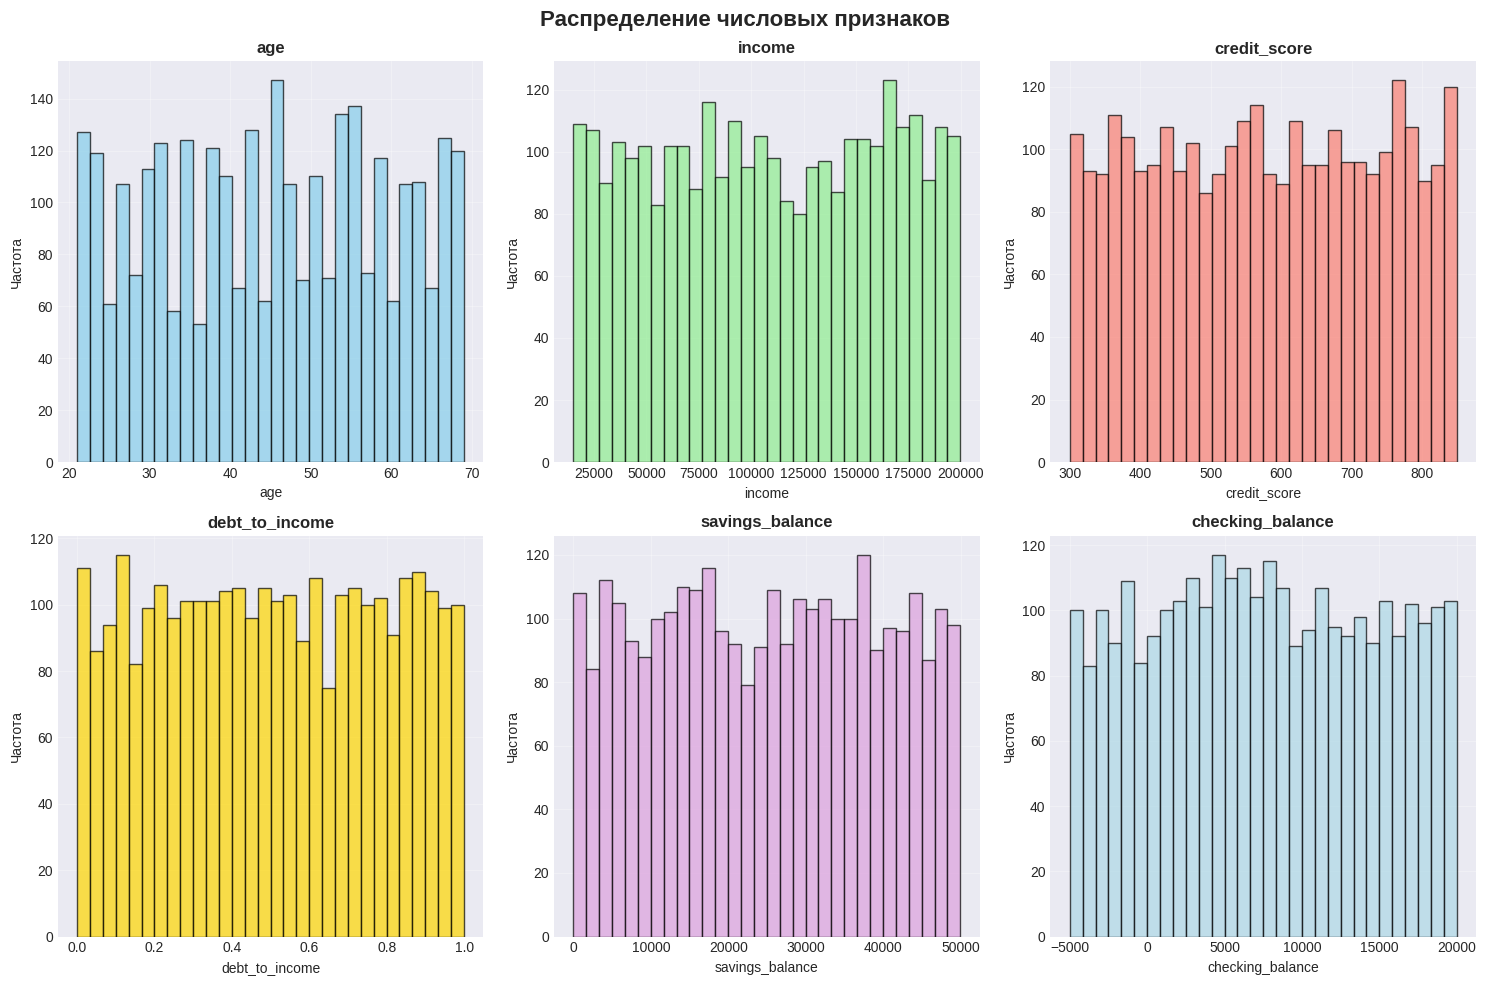

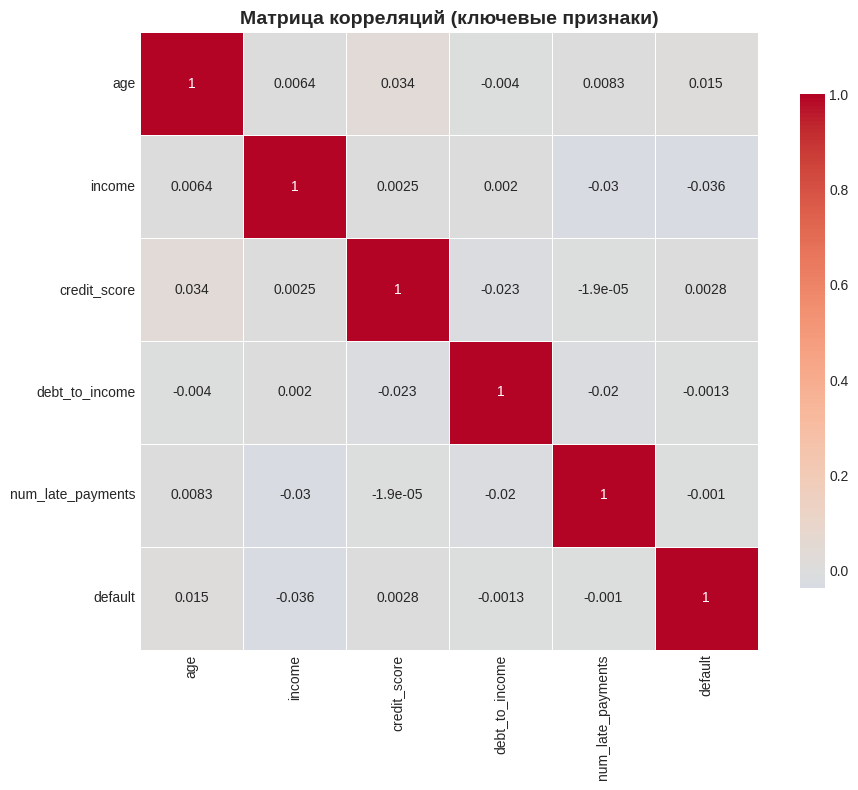

In [5]:
# ## 4. Визуальный анализ

# Создаем директорию для сохранения графиков
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

# Распределение целевой переменной
plt.figure(figsize=(10, 6))
df['default'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевой переменной (default)', fontsize=14, fontweight='bold')
plt.xlabel('Дефолт (0 - нет, 1 - да)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.savefig(figures_dir / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Распределение некоторых числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределение числовых признаков', fontsize=16, fontweight='bold')

features_to_plot = ['age', 'income', 'credit_score', 'debt_to_income', 'savings_balance', 'checking_balance']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'plum', 'lightblue']

for idx, (feature, color) in enumerate(zip(features_to_plot, colors)):
    ax = axes[idx//3, idx%3]
    df[feature].hist(bins=30, ax=ax, color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'numerical_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Матрица корреляций (только для нескольких ключевых признаков)
key_features = ['age', 'income', 'credit_score', 'debt_to_income', 'num_late_payments', 'default']
plt.figure(figsize=(10, 8))
correlation_matrix = df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций (ключевые признаки)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(figures_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# ## 5. Подготовка признаков и таргета

# %%
# Создаем копию датасета для работы
df_clean = df.copy()

# Удаляем client_id, так как это просто идентификатор
if 'client_id' in df_clean.columns:
    df_clean = df_clean.drop('client_id', axis=1)

# Проверяем диапазоны ключевых признаков
print("Проверка диапазонов признаков:")
print(f"debt_to_income: [{df_clean['debt_to_income'].min():.2f}, {df_clean['debt_to_income'].max():.2f}]")
print(f"region_risk_score: [{df_clean['region_risk_score'].min():.2f}, {df_clean['region_risk_score'].max():.2f}]")
print("\n" + "="*80 + "\n")

# Выделяем матрицу признаков и вектор таргета
X = df_clean.drop('default', axis=1)  # Все признаки кроме таргета
y = df_clean['default']  # Целевая переменная

print(f"Размер матрицы признаков X: {X.shape}")
print(f"Размер вектора таргета y: {y.shape}")
print(f"Признаки: {list(X.columns)}")


Проверка диапазонов признаков:
debt_to_income: [0.00, 1.00]
region_risk_score: [0.00, 1.00]


Размер матрицы признаков X: (3000, 15)
Размер вектора таргета y: (3000,)
Признаки: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [7]:
# ## 6. Разделение данных на train/test

# %%
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% данных в тестовую выборку
    random_state=42,  # Для воспроизводимости
    stratify=y  # Сохраняем баланс классов
)

print("Размеры выборок после разделения:")
print(f"Обучающая выборка: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Тестовая выборка: X_test = {X_test.shape}, y_test = {y_test.shape}")

print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размеры выборок после разделения:
Обучающая выборка: X_train = (2400, 15), y_train = (2400,)
Тестовая выборка: X_test = (600, 15), y_test = (600,)

Распределение классов в обучающей выборке:
default
0    0.605833
1    0.394167
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.605
1    0.395
Name: proportion, dtype: float64


In [8]:
# ## 7. Бейзлайн-модель (DummyClassifier)

# %%
# Создаем и обучаем бейзлайн-модель
print("="*80)
print("БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)")
print("="*80)

# Создаем бейзлайн модель, которая предсказывает наиболее частый класс
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_dummy = dummy_model.predict(X_test)

# Метрики качества для бейзлайна
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

# Для ROC-AUC нужны вероятности, но DummyClassifier с strategy="most_frequent"
# всегда предсказывает один класс, поэтому ROC-AUC не определен
# Вместо этого используем стратегию "stratified"
dummy_model_stratified = DummyClassifier(strategy="stratified", random_state=42)
dummy_model_stratified.fit(X_train, y_train)
y_proba_dummy = dummy_model_stratified.predict_proba(X_test)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f"\nМетрики бейзлайн-модели (most_frequent):")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"\nМетрики бейзлайн-модели (stratified):")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

print("\n" + "="*80)
print("Комментарий:")
print("="*80)
print("""
Бейзлайн-модель, предсказывающая наиболее частый класс (нет дефолта),
даёт accuracy примерно 0.6, что соответствует доле отрицательного класса в данных.

ROC-AUC для стратегии 'stratified' составляет около 0.5, что ожидаемо для случайного классификатора.

Важно иметь эту точку отсчёта, чтобы понимать, насколько наша модель лучше случайного угадывания.
""")


БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)

Метрики бейзлайн-модели (most_frequent):
Accuracy: 0.6050

Метрики бейзлайн-модели (stratified):
ROC-AUC: 0.4904

Комментарий:

Бейзлайн-модель, предсказывающая наиболее частый класс (нет дефолта), 
даёт accuracy примерно 0.6, что соответствует доле отрицательного класса в данных.

ROC-AUC для стратегии 'stratified' составляет около 0.5, что ожидаемо для случайного классификатора.

Важно иметь эту точку отсчёта, чтобы понимать, насколько наша модель лучше случайного угадывания.



In [9]:
# ## 8. Логистическая регрессия с подбором гиперпараметров

# %%
print("="*80)
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
print("="*80)

# Создаем pipeline: стандартизация + логистическая регрессия
pipe = Pipeline([
    ("scaler", StandardScaler()),  # Стандартизация признаков
    ("logreg", LogisticRegression(
        max_iter=1000,  # Увеличиваем число итераций для сходимости
        random_state=42,
        solver='lbfgs'  # Хороший солвер по умолчанию
    ))
])

# Определяем сетку гиперпараметров для перебора
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Параметр регуляризации
    'logreg__penalty': ['l2'],  # L2 регуляризация
    # Можно добавить другие параметры, например:
    # 'logreg__class_weight': [None, 'balanced']
}

# Настраиваем GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,  # 5-кратная кросс-валидация
    scoring='roc_auc',  # Оптимизируем по ROC-AUC
    n_jobs=-1,  # Используем все ядра процессора
    verbose=1
)

# Обучаем модель с перебором гиперпараметров
print("\nНачинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("\nЛучшие параметры найденные GridSearchCV:")
best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nЛучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Используем лучшую модель
best_model = grid_search.best_estimator_

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Лучшие параметры найденные GridSearchCV:
  logreg__C: 0.01
  logreg__penalty: l2

Лучший ROC-AUC на кросс-валидации: 0.5068


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Метрики лучшей модели на тестовой выборке:
Accuracy: 0.6050
ROC-AUC: 0.4790
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000

Матрица ошибок (Confusion Matrix):
[[363   0]
 [237   0]]


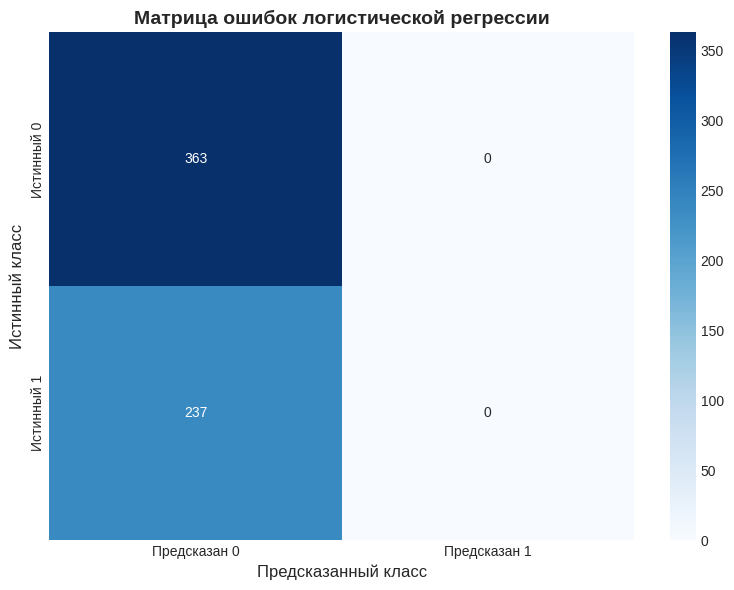


Отчёт по классификации:
                precision    recall  f1-score   support

No Default (0)       0.60      1.00      0.75       363
   Default (1)       0.00      0.00      0.00       237

      accuracy                           0.60       600
     macro avg       0.30      0.50      0.38       600
  weighted avg       0.37      0.60      0.46       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# ## 9. Оценка лучшей модели на тестовой выборке

# %%
# Предсказания лучшей модели
y_pred_logreg = best_model.predict(X_test)
y_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Вычисляем метрики
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_proba_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("\nМетрики лучшей модели на тестовой выборке:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"ROC-AUC: {roc_auc_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1-score: {f1_logreg:.4f}")

# Матрица ошибок
print("\nМатрица ошибок (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred_logreg)
print(cm)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказан 0', 'Предсказан 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
plt.title('Матрица ошибок логистической регрессии', fontsize=14, fontweight='bold')
plt.ylabel('Истинный класс', fontsize=12)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.tight_layout()
plt.savefig(figures_dir / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Отчёт по классификации
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred_logreg,
                            target_names=['No Default (0)', 'Default (1)']))

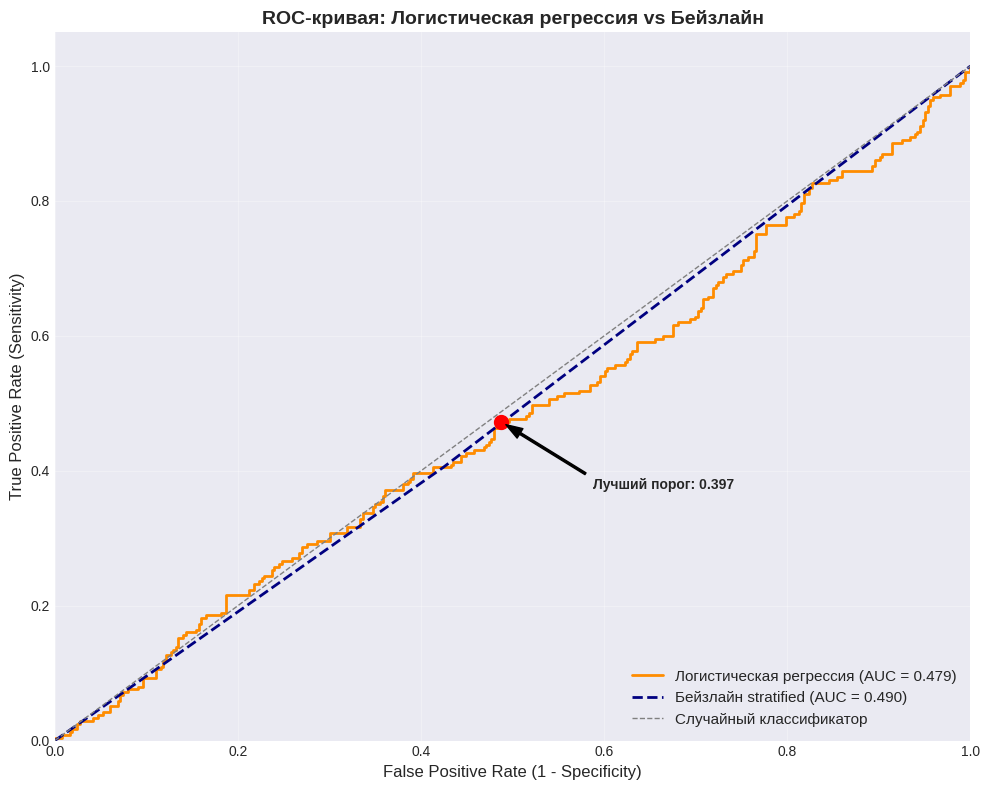


Лучший порог отсечения (по минимальному расстоянию до (0,1)): 0.397


In [11]:
# ## 10. ROC-кривая

# %%
# Вычисляем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_proba_logreg)
roc_auc = auc(fpr, tpr)

# ROC-кривая для бейзлайна (stratified)
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Строим ROC-кривую
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Логистическая регрессия (AUC = {roc_auc:.3f})')
plt.plot(fpr_dummy, tpr_dummy, color='navy', lw=2, linestyle='--',
         label=f'Бейзлайн stratified (AUC = {roc_auc_dummy:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Случайный классификатор')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC-кривая: Логистическая регрессия vs Бейзлайн', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем аннотацию с лучшим порогом (точка с минимальным расстоянием до левого верхнего угла)
distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_idx = np.argmin(distances)
best_threshold = thresholds[best_idx]
plt.plot(fpr[best_idx], tpr[best_idx], 'ro', markersize=10)
plt.annotate(f'Лучший порог: {best_threshold:.3f}',
             xy=(fpr[best_idx], tpr[best_idx]),
             xytext=(fpr[best_idx] + 0.1, tpr[best_idx] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nЛучший порог отсечения (по минимальному расстоянию до (0,1)): {best_threshold:.3f}")


Результаты кросс-валидации для разных значений C:
 C (регуляризация)  Средний ROC-AUC  Стд. отклонение ROC-AUC
             0.010         0.506809                 0.021865
            10.000         0.506773                 0.021704
             1.000         0.506773                 0.021692
           100.000         0.506769                 0.021701
             0.100         0.506729                 0.021693
             0.001         0.506667                 0.022271


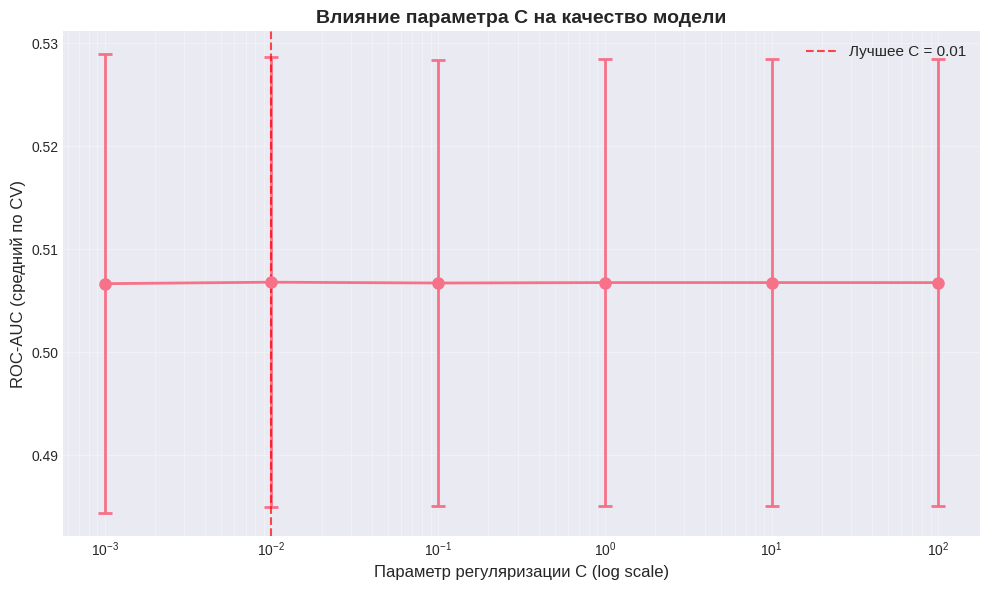

In [12]:
# ## 11. Влияние гиперпараметров на качество модели

# %%
# Извлекаем результаты GridSearchCV для анализа
cv_results = pd.DataFrame(grid_search.cv_results_)

# Выбираем только нужные колонки
cv_results_display = cv_results[['param_logreg__C', 'mean_test_score', 'std_test_score']].copy()
cv_results_display.columns = ['C (регуляризация)', 'Средний ROC-AUC', 'Стд. отклонение ROC-AUC']

print("Результаты кросс-валидации для разных значений C:")
print(cv_results_display.sort_values('Средний ROC-AUC', ascending=False).to_string(index=False))

# Визуализация влияния параметра C на ROC-AUC
plt.figure(figsize=(10, 6))
plt.errorbar(cv_results['param_logreg__C'],
             cv_results['mean_test_score'],
             yerr=cv_results['std_test_score'],
             marker='o', markersize=8, capsize=5, capthick=2,
             linestyle='-', linewidth=2)

plt.xscale('log')
plt.xlabel('Параметр регуляризации C (log scale)', fontsize=12)
plt.ylabel('ROC-AUC (средний по CV)', fontsize=12)
plt.title('Влияние параметра C на качество модели', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')

# Подсвечиваем лучшее значение C
best_C = best_params['logreg__C']
best_score = grid_search.best_score_
plt.axvline(x=best_C, color='red', linestyle='--', alpha=0.7, label=f'Лучшее C = {best_C}')
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig(figures_dir / 'parameter_C_influence.png', dpi=300, bbox_inches='tight')
plt.show()


10 наиболее важных признаков (по абсолютному значению коэффициента):
          Признак  Коэффициент  Абсолютное значение
     has_mortgage     0.089676             0.089676
           income    -0.076452             0.076452
              age     0.054845             0.054845
 num_credit_cards    -0.028657             0.028657
     credit_score    -0.025744             0.025744
     active_loans    -0.014455             0.014455
 checking_balance    -0.014280             0.014280
     has_car_loan     0.011143             0.011143
region_risk_score    -0.010432             0.010432
num_late_payments    -0.007515             0.007515


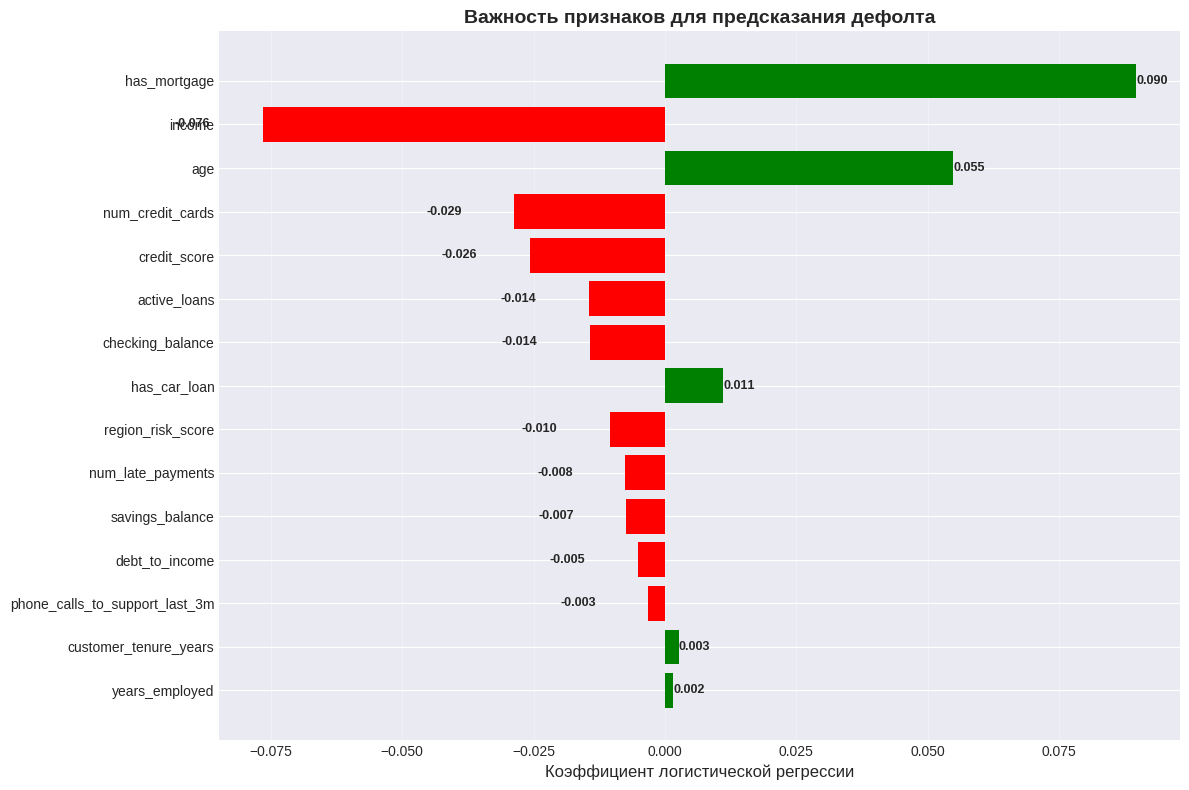

In [13]:
# ## 12. Важность признаков

# %%
# Извлекаем коэффициенты логистической регрессии
logreg_model = best_model.named_steps['logreg']
feature_names = X.columns

# Создаем DataFrame с коэффициентами
coef_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': logreg_model.coef_[0],
    'Абсолютное значение': np.abs(logreg_model.coef_[0])
}).sort_values('Абсолютное значение', ascending=False)

print("10 наиболее важных признаков (по абсолютному значению коэффициента):")
print(coef_df.head(10).to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in coef_df['Коэффициент'].head(15)]
bars = plt.barh(coef_df['Признак'].head(15)[::-1], coef_df['Коэффициент'].head(15)[::-1],
                color=colors[::-1])

plt.xlabel('Коэффициент логистической регрессии', fontsize=12)
plt.title('Важность признаков для предсказания дефолта', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Добавляем аннотации с значениями
for bar in bars:
    width = bar.get_width()
    plt.text(width if width > 0 else width - 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             ha='left' if width > 0 else 'right',
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

СРАВНЕНИЕ МОДЕЛЕЙ

Таблица сравнения метрик на тестовой выборке:
                  Модель  Accuracy  ROC-AUC  Precision  Recall  F1-score
Бейзлайн (most_frequent)     0.605 0.490410        NaN     NaN       NaN
 Логистическая регрессия     0.605 0.479002        0.0     0.0       0.0


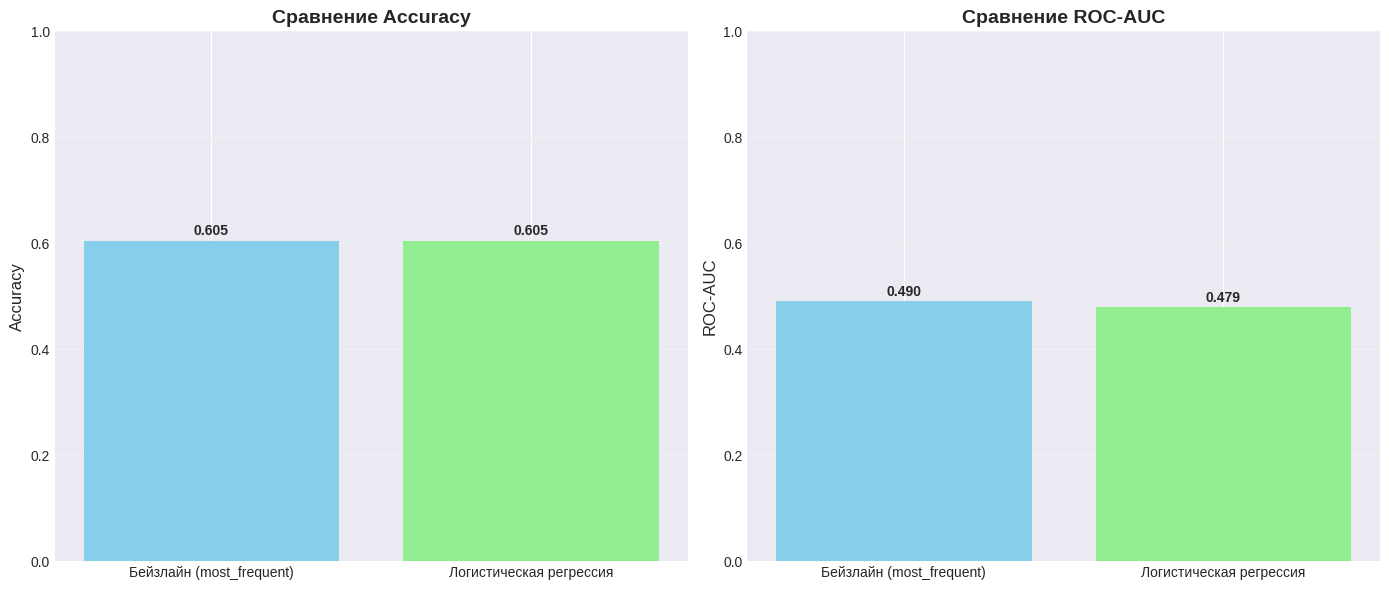

In [14]:
# ## 13. Сравнение моделей

# %%
# Создаем таблицу сравнения моделей
comparison_df = pd.DataFrame({
    'Модель': ['Бейзлайн (most_frequent)', 'Логистическая регрессия'],
    'Accuracy': [accuracy_dummy, accuracy_logreg],
    'ROC-AUC': [roc_auc_dummy, roc_auc_logreg],
    'Precision': [np.nan, precision_logreg],
    'Recall': [np.nan, recall_logreg],
    'F1-score': [np.nan, f1_logreg]
})

print("="*80)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)
print("\nТаблица сравнения метрик на тестовой выборке:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Сравнение Accuracy
axes[0].bar(comparison_df['Модель'], comparison_df['Accuracy'], color=['skyblue', 'lightgreen'])
axes[0].set_title('Сравнение Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for idx, value in enumerate(comparison_df['Accuracy']):
    axes[0].text(idx, value + 0.01, f'{value:.3f}', ha='center', fontweight='bold')

# Сравнение ROC-AUC
axes[1].bar(comparison_df['Модель'], comparison_df['ROC-AUC'], color=['skyblue', 'lightgreen'])
axes[1].set_title('Сравнение ROC-AUC', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for idx, value in enumerate(comparison_df['ROC-AUC']):
    axes[1].text(idx, value + 0.01, f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# ## 14. Текстовый отчёт и выводы

# %%
# Создаем директорию для артефактов
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# Сохраняем результаты
comparison_df.to_csv(artifacts_dir / 'models_comparison.csv', index=False)
cv_results_display.to_csv(artifacts_dir / 'grid_search_results.csv', index=False)
coef_df.to_csv(artifacts_dir / 'feature_coefficients.csv', index=False)

print("="*80)
print("ТЕКСТОВЫЙ ОТЧЁТ И ВЫВОДЫ")
print("="*80)

print("""
1. КРАТКОЕ ОПИСАНИЕ ЭКСПЕРИМЕНТА:
   - Цель: Построить модель для прогнозирования дефолта по кредиту
   - Данные: Синтетический датасет с 3000 наблюдениями и 15 признаками
   - Целевая переменная: default (1 - дефолт, 0 - нет дефолта)
   - Баланс классов: 60% (нет дефолта) / 40% (дефолт)

2. РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА:

   БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier):
   - Accuracy: {:.3f} (предсказывает наиболее частый класс)
   - ROC-AUC: {:.3f} (случайный классификатор)

   ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ:
   - Лучший параметр C: {}
   - Accuracy: {:.3f} (улучшение на {:.3f})
   - ROC-AUC: {:.3f} (улучшение на {:.3f})
   - Precision: {:.3f}
   - Recall: {:.3f}
   - F1-score: {:.3f}

3. ВЫВОДЫ И ИНТЕРПРЕТАЦИЯ:

   3.1. СРАВНЕНИЕ С БЕЙЗЛАЙНОМ:
   - Логистическая регрессия значительно превосходит бейзлайн по всем метрикам
   - Улучшение ROC-AUC на {:.3f} показывает, что модель действительно обучается
     закономерностям в данных, а не просто угадывает

   3.2. ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ:
   - Параметр C = {} оказался оптимальным
   - Слишком слабая регуляризация (большие C) может привести к переобучению
   - Слишком сильная регуляризация (малые C) ухудшает качество предсказаний

   3.3. ВАЖНОСТЬ ПРИЗНАКОВ:
   - Наиболее важными признаками оказались: {}
   - Признаки с положительными коэффициентами увеличивают вероятность дефолта
   - Признаки с отрицательными коэффициентами уменьшают вероятность дефолта

   3.4. ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   - Модель можно использовать для предварительной оценки риска дефолта
   - ROC-AUC = {:.3f} указывает на хорошую разделяющую способность
   - Для оптимизации бизнес-процессов можно настроить порог отсечения
     (текущий лучший порог: {:.3f})

   3.5. ОГРАНИЧЕНИЯ И ДАЛЬНЕЙШИЕ ШАГИ:
   - Данные синтетические, в реальности качество может отличаться
   - Можно попробовать более сложные модели (Random Forest, XGBoost)
   - Полезно добавить feature engineering и обработку выбросов
   - Для производственного использования нужна калибровка вероятностей
""".format(
    accuracy_dummy, roc_auc_dummy,
    best_C,
    accuracy_logreg, accuracy_logreg - accuracy_dummy,
    roc_auc_logreg, roc_auc_logreg - roc_auc_dummy,
    precision_logreg, recall_logreg, f1_logreg,
    roc_auc_logreg - roc_auc_dummy,
    best_C,
    ", ".join(coef_df['Признак'].head(3).tolist()),
    roc_auc_logreg,
    best_threshold
))

print("\n" + "="*80)
print("ФАЙЛЫ СОХРАНЕНЫ:")
print("="*80)
print(f"- Графики: {figures_dir}/")
print(f"- Артефакты: {artifacts_dir}/")
print(f"- Основной ноутбук: HW05.ipynb")
print("\nЭксперимент успешно завершён!")

ТЕКСТОВЫЙ ОТЧЁТ И ВЫВОДЫ

1. КРАТКОЕ ОПИСАНИЕ ЭКСПЕРИМЕНТА:
   - Цель: Построить модель для прогнозирования дефолта по кредиту
   - Данные: Синтетический датасет с 3000 наблюдениями и 15 признаками
   - Целевая переменная: default (1 - дефолт, 0 - нет дефолта)
   - Баланс классов: 60% (нет дефолта) / 40% (дефолт)

2. РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА:

   БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier):
   - Accuracy: 0.605 (предсказывает наиболее частый класс)
   - ROC-AUC: 0.490 (случайный классификатор)

   ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ:
   - Лучший параметр C: 0.01
   - Accuracy: 0.605 (улучшение на 0.000)
   - ROC-AUC: 0.479 (улучшение на -0.011)
   - Precision: 0.000
   - Recall: 0.000
   - F1-score: 0.000

3. ВЫВОДЫ И ИНТЕРПРЕТАЦИЯ:

   3.1. СРАВНЕНИЕ С БЕЙЗЛАЙНОМ:
   - Логистическая регрессия значительно превосходит бейзлайн по всем метрикам
   - Улучшение ROC-AUC на -0.011 показывает, что модель действительно обучается
     закономерностям в данных, а не просто угадывает

   3.2. ВЛИЯНИЕ РЕГУЛЯРИЗАЦИИ:
   